# Intro

In [2]:
# Data
import os
import numpy as np
import pandas as pd

# SkLearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Display
from IPython.display import clear_output

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Gradient Boosting
import xgboost as xgb

# Import/Export
import pickle
import joblib

# Optimización Inversa
from scipy.optimize import differential_evolution, minimize

In [35]:
import sys
import sklearn

# Versión de Python (y por ende de pickle)
print("Versión de Python:", sys.version)

# Versión de scikit-learn
print("Versión de scikit-learn:", sklearn.__version__)


Versión de Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Versión de scikit-learn: 1.2.2


In [3]:
REPO_NAME = "Multi-Parameter_Wireless_Network"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/MiguelMussi/{REPO_NAME}.git
  os.chdir(REPO_NAME)

Establecer GPU por defecto en caso de estar disponible.

In [4]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
with open('datos.txt', 'r') as file:
    data = file.read()
lines = data.strip().split('\n')
rows = [line.split() for line in lines]
df = pd.DataFrame(rows)
df = df.apply(pd.to_numeric)

In [6]:
df.shape

(33351, 227)

### Funciones

In [7]:
def renombrar_columnas(df):
    new_col_names = []
    for i in range(1, 57):
        new_col_names.extend([f'{i}a', f'{i}b', f'{i}c', f'{i}d'])
    new_col_names.extend(['R1', 'R2', 'R3'])
    df.columns = new_col_names
    return df

In [8]:
def eliminar_registros_duplicados(df):
    df_clean = df.drop_duplicates()
    return df_clean

In [9]:
def escalar_datos(df, scaler_dict=None):
    if scaler_dict is None:
        scaler_dict = {}
    for columna in df.columns:
        if columna not in scaler_dict:
            scaler_dict[columna] = MinMaxScaler()
        df[columna] = scaler_dict[columna].fit_transform(df[[columna]])
    return df, scaler_dict

In [10]:
def separar_Xy(df, columnas_target):
    X = df.drop(columnas_target, axis=1).copy()
    y = df[columnas_target].copy()
    return X, y

In [11]:
def r2_ajustado(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    r2_aj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return r2_aj

### Procesamiento

In [12]:
df = renombrar_columnas(df)
df = eliminar_registros_duplicados(df)

In [13]:
df

,1a,1b,1c,1d,2a,2b,2c,2d,3a,3b,...,55b,55c,55d,56a,56b,56c,56d,R1,R2,R3
0,100,5,15,25,250,7,45,25,20,11,...,20,110,25,80,3,90,12,12.42,8.52,21.36
1,100,3,105,6,260,7,90,6,20,11,...,6,25,12,30,7,45,12,18.92,6.64,21.18
2,110,-3,45,12,250,7,45,25,20,3,...,14,65,12,30,13,110,6,12.63,6.59,17.89
3,100,3,105,6,270,3,105,6,330,13,...,10,25,25,70,15,110,25,11.07,9.36,22.05
4,100,3,105,6,280,11,15,12,330,13,...,10,25,6,80,3,90,12,15.78,7.42,20.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33346,100,3,105,6,270,3,105,6,0,3,...,12,105,6,60,5,105,6,13.96,6.05,18.45
33347,100,3,105,6,270,3,105,6,0,3,...,12,105,6,60,5,105,6,21.56,5.56,22.13
33348,100,3,105,6,270,3,105,6,0,3,...,12,105,6,60,5,105,6,17.41,6.01,20.87
33349,100,3,105,6,270,3,105,6,0,3,...,12,105,6,60,5,105,6,15.63,6.21,19.22


In [15]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=123)

In [16]:
df_train, train_scaler_dict = escalar_datos(df_train)

In [17]:
columnas_target = ['R1', 'R2', 'R3']

In [18]:
X_train, y_train = separar_Xy(df_train, columnas_target=columnas_target)

In [19]:
df_test_out = df_test.copy()
df_test_out, _ = escalar_datos(df_test_out, train_scaler_dict)
X_test, y_test = separar_Xy(df_test_out, columnas_target=columnas_target)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27743, 224), (27743, 3), (3083, 224), (3083, 3))

# Ensamble

## MLP Model

In [21]:
mlp_model = MLPRegressor(hidden_layer_sizes=(500, 200, 100, 50, 10 ), activation='relu', solver='adam', max_iter=300)
mlp_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(500, 200, 100, 50, 10), max_iter=300)

## DNN Model

In [22]:
# Arquitectura
# dnn_model = Sequential([
#     Input(shape=(X_train.shape[1],)),
#     Dense(256, activation='relu'), Dropout(0.2),
#     Dense(32, activation='relu'), Dropout(0.2),
#     Dense(3, activation='linear')
# ])

dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'), Dropout(0.2),
    Dense(512, activation='relu'), Dropout(0.2),
    Dense(256, activation='relu'), Dropout(0.2),
    Dense(128, activation='relu'), Dropout(0.2),
    Dense(64, activation='relu'), Dropout(0.2),
    Dense(32, activation='relu'), Dropout(0.2),
    Dense(3, activation='linear')
])

# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")

# CallBacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20, verbose=0, mode="min")
checkpoint_loss = ModelCheckpoint("model-e{epoch:02d}-loss{val_loss:.3f}", save_best_only=True,
    monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min")

callbacks=[reduce_lr, early_stopping]
dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error', 'mae'])
dnn_model.fit(X_train, y_train, epochs=200, batch_size=64, callbacks=callbacks, validation_split=0.2, verbose=1)
clear_output(wait=True)
print("-------------------------\nFin del Entrenamiento")

-------------------------
Fin del Entrenamiento


## RandomForest

In [23]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Gradient Boosting

In [24]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=6, random_state=123)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

## -- Meta Model --

### Predicciones Modelos Base

In [25]:
# Obtener predicciones del conjunto de entrenamiento
mlp_train_preds = mlp_model.predict(X_train)
rf_train_preds = rf_model.predict(X_train)
xgb_train_preds = xgb_model.predict(X_train)
dnn_train_preds = dnn_model.predict(X_train)

# Concatenar todas las predicciones para formar un nuevo conjunto de características para el meta-modelo
meta_X_train = np.concatenate((mlp_train_preds, rf_train_preds, xgb_train_preds, dnn_train_preds), axis=1)

# Obtener predicciones del conjunto de prueba
mlp_test_preds = mlp_model.predict(X_test)
rf_test_preds = rf_model.predict(X_test)
xgb_test_preds = xgb_model.predict(X_test)
dnn_test_preds = dnn_model.predict(X_test)

# Concatenar todas las predicciones para formar un nuevo conjunto de características para el meta-modelo
meta_X_test = np.concatenate((mlp_test_preds, rf_test_preds, xgb_test_preds, dnn_test_preds), axis=1)

97/97 [==============================] - 0s 2ms/step


In [26]:
mlp_test_preds.shape, rf_test_preds.shape, xgb_test_preds.shape, dnn_test_preds.shape

((3083, 3), (3083, 3), (3083, 3), (3083, 3))

### RandomForest

In [29]:
meta_model = RandomForestRegressor(n_estimators=500, random_state=42)
meta_model.fit(meta_X_train, y_train)

# Evaluar el meta-modelo en el conjunto de prueba
meta_predictions = meta_model.predict(meta_X_test)
mse = mean_squared_error(y_test, meta_predictions)
print(f'MSE - Mean Squared Error del meta-modelo: {mse}')

MSE - Mean Squared Error del meta-modelo: 0.0012705096078655274


In [38]:
meta_X_test.shape

(3083, 12)

In [ ]:
# 100 - 0.002789
# 200 - 0.002780
# 500 - 0.002774 / 0.002513 / 0.002770
# 1000 - 0.002775

In [ ]:
# 0.002279

In [ ]:
# 0.001270 Set de Datos 33351

In [ ]:
# 0.001179 Set de Datos 25000

### Predicciones y Métricas

In [30]:
predicciones = pd.DataFrame(df_test, columns=df_test.columns)
for i, columna in enumerate(['R1', 'R2', 'R3']):
    predicciones[f'P_{columna}'] = train_scaler_dict[columna].inverse_transform(meta_predictions[:, i].reshape(-1, 1))
predicciones

,1a,1b,1c,1d,2a,2b,2c,2d,3a,3b,...,56a,56b,56c,56d,R1,R2,R3,P_R1,P_R2,P_R3
26513,70,1,65,25,250,7,45,25,350,7,...,70,15,110,25,3.92,1.30,4.24,3.866342,1.286222,4.159678
33307,100,3,105,6,270,3,105,6,0,3,...,60,5,105,6,21.13,5.52,21.95,21.151508,5.351185,21.253827
13019,70,13,105,6,280,11,15,12,330,13,...,30,13,110,6,31.85,4.79,24.63,31.772095,4.616325,25.262694
19010,100,3,105,6,280,11,15,12,350,7,...,70,15,110,25,3.76,1.25,4.24,3.819529,1.297546,4.215673
8977,110,-3,45,12,250,3,65,25,0,5,...,30,7,45,12,6.29,8.26,17.56,5.950371,7.509828,16.965384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28096,100,5,15,25,250,7,45,25,350,7,...,70,15,110,25,2.67,1.31,4.36,2.655245,1.362503,4.382482
33297,100,3,105,6,270,3,105,6,0,3,...,60,5,105,6,20.54,5.52,22.76,20.066925,5.417196,21.904111
23928,70,-1,25,25,250,3,65,25,0,3,...,40,5,110,25,12.43,5.24,16.32,10.459630,5.604184,14.710847
23786,100,5,15,25,300,13,110,12,330,13,...,70,5,15,25,21.23,5.38,20.18,20.961101,5.912489,21.026616


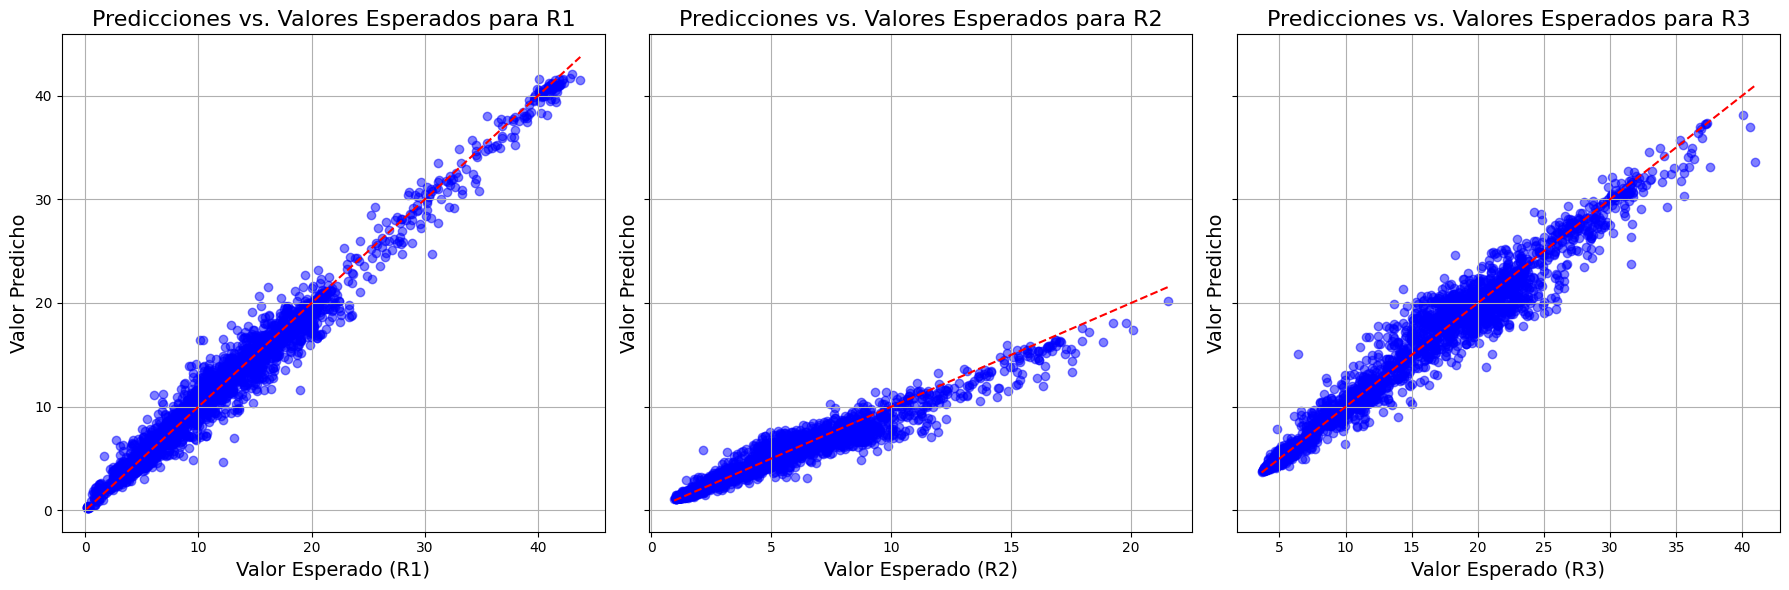

In [32]:
# Crear subgráficos
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Iterar sobre las columnas de predicción
for i, columna in enumerate(['R1', 'R2', 'R3']):
    # Scatter plot de los valores esperados vs. predichos para la columna actual
    axs[i].scatter(predicciones[columna], predicciones[f'P_{columna}'], color='blue', alpha=0.5)
    # Línea diagonal para referencia
    axs[i].plot([predicciones[columna].min(), predicciones[columna].max()], [predicciones[columna].min(), predicciones[columna].max()], color='red', linestyle='--')
    # Título y etiquetas de los ejes
    axs[i].set_title(f'Predicciones vs. Valores Esperados para {columna}', fontsize=16)
    axs[i].set_xlabel(f'Valor Esperado ({columna})', fontsize=14)
    axs[i].set_ylabel('Valor Predicho', fontsize=14)
    # Cuadrícula
    axs[i].grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [34]:
# Métricas
print("-------------------------\nMétricas")
y_pred = meta_predictions
# Calcular R2 ajustado
n = y_test.shape[0] * y_test.shape[1]  # número total de observaciones en y_test
p = X_train.shape[1] # número de características en X_train
r2_aj = r2_ajustado(y_test, y_pred, n, p)

# Métricas de regresión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE): {:.6f}".format(mse))
print("Mean Absolute Error (MAE): {:.6f}".format(mae))
print("R2 Score: {:.6f}".format(r2))
print("R2 Ajustado: {:.6f}\n".format(r2_aj))

-------------------------
Métricas
Mean Squared Error (MSE): 0.001271
Mean Absolute Error (MAE): 0.022589
R2 Score: 0.963742
R2 Ajustado: 0.962842



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


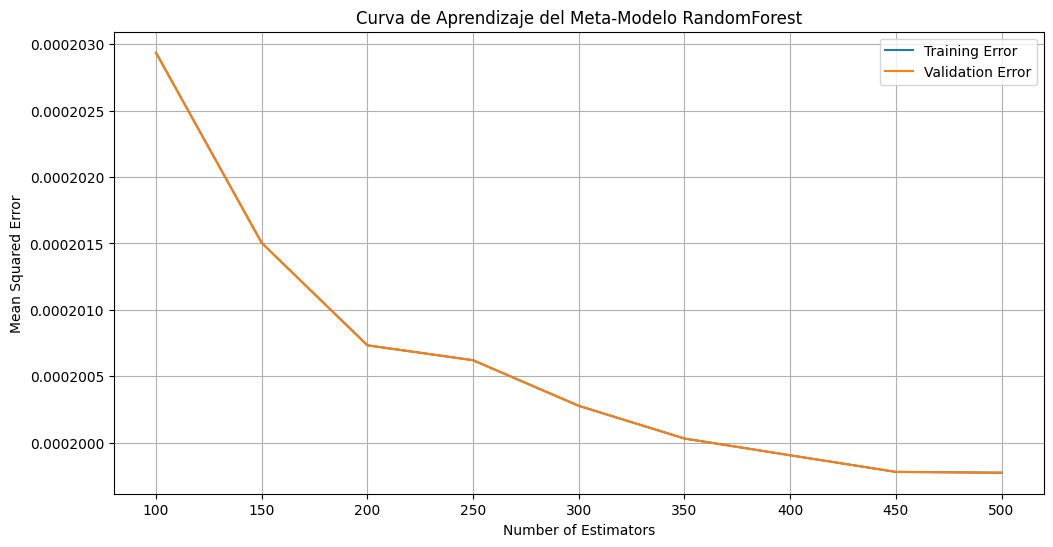

In [ ]:
from sklearn.model_selection import cross_val_score

# Función para graficar la curva de aprendizaje del meta-modelo RandomForest
def plot_learning_curve(model, X, y, cv=5):
    """
    Graficar la curva de aprendizaje del modelo.

    Parameters:
    model (sklearn estimator): El modelo a evaluar.
    X (numpy array): Conjunto de características.
    y (numpy array): Conjunto de etiquetas.
    cv (int): Número de pliegues para la validación cruzada.
    """
    train_scores = []
    val_scores = []
    n_estimators_range = range(100, 501, 50)

    for n_estimators in n_estimators_range:
        model.set_params(n_estimators=n_estimators)
        train_scores.append(np.mean(cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)))
        val_scores.append(np.mean(cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)))

    train_scores = np.array(train_scores) * -1  # Convertir a valores positivos
    val_scores = np.array(val_scores) * -1  # Convertir a valores positivos

    plt.figure(figsize=(12, 6))
    plt.plot(n_estimators_range, train_scores, label='Training Error')
    plt.plot(n_estimators_range, val_scores, label='Validation Error')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.title('Curva de Aprendizaje del Meta-Modelo RandomForest')
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar la curva de aprendizaje
plot_learning_curve(meta_model, meta_X_train, y_train)


# Import / Export de Modelos

TensorFlow

In [ ]:
model.save('meta_model')

In [ ]:
loaded_model = tf.keras.models.load_model('mlp_model')

Pickle

In [ ]:
# Guardar el modelo
with open('meta_model.pkl', 'wb') as file:
    pickle.dump(meta_model, file)

In [ ]:
# Cargar el modelo
with open('meta_model.pkl', 'rb') as file:
    loaded_meta_model = pickle.load(file)

In [ ]:
mlp.save('mlp_model.h5')
with open('mlp_model_pickle.pkl', 'wb') as file:
    pickle.dump('mlp_model.h5', file)

In [ ]:
with open('mlp_model_pickle.pkl', 'rb') as file:
    model_file = pickle.load(file)
loaded_model = tf.keras.models.load_model(model_file)

Joblib

In [ ]:
joblib.dump(mlp, 'mlp_regressor_model.pkl')

['mlp_regressor_model.pkl']

In [ ]:
mlp_loaded = joblib.load('mlp_regressor_model.pkl')

# Sección nueva

In [ ]:
def meta_predict(input):
    input = np.array(input).reshape(1, -1)

    mlp_meta_preds = mlp_model.predict(input)
    rf_meta_preds = rf_model.predict(input)
    xgb_meta_preds = xgb_model.predict(input)
    dnn_meta_preds = dnn_model.predict(input)

    meta_input = np.hstack((mlp_meta_preds, rf_meta_preds, xgb_meta_preds, dnn_meta_preds))
    meta_predictions = meta_model.predict(meta_input)

    R1, R2, R3 = meta_predictions[0], meta_predictions[1], meta_predictions[2]
    return R1, R2, R3


In [36]:
from typing import List, Tuple, Dict
import random
import numpy as np
import pickle
import time

N_INPUT_x_ANTENNA = 4
def temp_schedule_lineal(t0,tf,pje):
    t = t0 + (tf-t0)*pje
    return t

def temp_schedule_exp(t0,tf,pje):
    return t0 * pow(tf/t0,pje)

def calc_score(R1:float,R2:float,R3:float):
    u1=100.-max(R1,R2,R3)
    u2=100.-(R1+R2+R3)/3.
    score1 = (u1 - u10) * invu10
    score2 = (u2 - u20) * invu20
    score = (score1 + score2) * score_scale
    return score

# def get_prediction(values)->float:
#     val  = np.array(values)
#     val = val.reshape(1,-1)
#     R1,R2,R3 = model.predict(val)[0]
#     return calc_score(R1,R2,R3)

def get_prediction(values):
    # Obtén las predicciones parciales y finales
    R1, R2, R3 = meta_predict(values)
    return calc_score(R1, R2, R3)

class State:
    def __init__(self,case:int,parameters:List[List[int]]):
        self.case: int = case
        self.indices: List[int] = []
        self.values: List[int] = []
        self.parameters: List[List[int]] = parameters
        self.next_state_ants:List[int] = [0,0,0]
        self.next_state_old_idxs:List[int] = [0,0,0]
        self.next_tipo:int
        self.sitios = [[0,1,2],[3,4,5],[6,7,8],[9,10],[11,12,13],[14,15,16],[17,18],[19,20,21],[22,23,24],[25,26,27],[28,29],[30,31,32],[33,34,35],[36,37,38],[39,40,41],[42,43],[44,45,46],[47,48,49],[53,54,55]]

    def gen_inicial(self):
        self.indices = [0]*56
        for ant in range(56):
            for j in range(N_INPUT_x_ANTENNA):
                self.values.append(self.parameters[ant*20 + self.indices[ant]][j])

    def gen_best(self):
        indices_caso = [[7,15,6,19,11,12,5,11,11,1,5,12,18,18,13,6,17,8,19,7,17,5,14,8,1,13,13,6,19,19,15,16,11,6,2,4,3,10,16,8,14,2,10,10,6,7,10,2,3,16,19,6,17,2,6,10],
                                  [1,16,12,16,14,11,14,8,6,2,12,18,16,3,14,10,19,15,17,3,6,3,1,14,19,13,3,1,1,19,5,5,8,12,4,0,13,4,15,8,12,11,8,6,6,1,19,15,12,17,13,8,1,17,12,3],
                                   [5,14,14,10,1,10,4,19,6,8,9,9,3,15,10,2,12,0,6,16,2,16,13,1,19,2,11,16,1,6,13,8,13,18,8,0,1,1,12,0,10,4,3,12,12,9,11,10,3,7,1,11,7,8,1,7],
                            [12,0,1,16,10,7,15,2,7,3,0,12,10,14,14,10,14,12,14,8,4,9,10,16,8,15,1,13,14,10,17,16,4,3,16,0,14,8,2,4,18,4,7,5,9,4,9,5,3,3,6,14,14,2,15,14],
                            [16,11,1,12,9,0,15,16,7,17,10,2,11,14,12,4,0,3,10,17,19,12,12,10,5,1,15,13,9,6,19,5,11,13,12,12,5,13,15,9,9,14,19,8,3,8,3,8,7,18,5,8,14,18,12,14],
                            [14,12,19,10,13,5,3,11,1,2,7,6,5,4,10,9,0,9,3,2,9,0,1,6,8,2,6,16,7,2,2,14,9,4,9,0,17,4,13,9,14,7,17,11,13,5,12,14,7,16,8,5,11,14,8,13]]


        self.indices = indices_caso[self.case]
        self.values = []
        for ant in range(56):
            for j in range(N_INPUT_x_ANTENNA):
                self.values.append(self.parameters[ant * 20 + self.indices[ant]][j])
        print(self.values)

    def gen_subrandom(self):
        self.indices = [random.randint(0,19) for _ in range(56)]
        self.indices[6] = 8
        self.indices[7] = 14 # 10
        self.indices[8] =  18 # 17
        self.indices[9] =  12
        self.indices[10] = 2
        self.indices[11] =  11
        self.indices[12] =  17 # 9
        self.indices[13] =  13
        self.indices[14] =  8 #0
        self.values = []
        for ant in range(56):
            for j in range(N_INPUT_x_ANTENNA):
                self.values.append(self.parameters[ant*20 + self.indices[ant]][j])

    def gen_random(self):
        self.indices = [random.randint(0,19) for _ in range(56)]
        self.values = []
        for ant in range(56):
            for j in range(N_INPUT_x_ANTENNA):
                self.values.append(self.parameters[ant*20 + self.indices[ant]][j])

    def upd_all_values(self):
        for ant in range(56):
            self.upd_values(ant)


    def upd_values(self,antenna:int):
        self.values[antenna*N_INPUT_x_ANTENNA:antenna*N_INPUT_x_ANTENNA+N_INPUT_x_ANTENNA] = self.parameters[antenna*20 + self.indices[antenna]][:]


    def next_state(self):
        self.next_tipo = np.random.randint(3)

        if self.next_tipo==2:
            sitio = np.random.randint(19)
            self.next_tipo = len(self.sitios[sitio])-1
            for i in range(self.next_tipo+1):
                ant = self.sitios[sitio][i]
                self.next_state_ants[i] = ant
                self.next_state_old_idxs[i] = self.indices[ant]
                self.indices[ant] = np.random.randint(20)
                self.upd_values(ant)
        else:
            self.next_state_ants[0] = np.random.randint(56)
            self.next_state_old_idxs[0] = self.indices[self.next_state_ants[0]]
            self.indices[self.next_state_ants[0]] = np.random.randint(20)
            while self.next_state_old_idxs[0]==self.indices[self.next_state_ants[0]]:
                self.indices[self.next_state_ants[0]] = np.random.randint(20)
            self.upd_values(self.next_state_ants[0])

            if self.next_tipo == 1:
                self.next_state_ants[1] = np.random.randint(56)
                while self.next_state_ants[1]==self.next_state_ants[0]:
                    self.next_state_ants[1] = np.random.randint(56)
                self.next_state_old_idxs[1] = self.indices[self.next_state_ants[1]]
                self.indices[self.next_state_ants[1]] = np.random.randint(20)
                while self.next_state_old_idxs[1]==self.indices[self.next_state_ants[1]]:
                    self.indices[self.next_state_ants[1]] = np.random.randint(20)
                self.upd_values(self.next_state_ants[1])


        return self.calc_state_score()


    def undo_next_state(self):
        for i in range(self.next_tipo+1):
            self.indices[self.next_state_ants[i]] = self.next_state_old_idxs[i]
            self.upd_values(self.next_state_ants[i])


    def calc_state_score(self):
        return get_prediction(self.values)

def sa(state:State,score:float,iters:int):
    best_score = score
    best_indices = state.indices.copy()
    t0 = 10
    tf = .1
    loop_iters = 20
    iters //= loop_iters
    for it in range(iters):
        if divmod(it,4095)[1] == 0:
            print(it,score)
        temp = temp_schedule_exp(t0,tf,it/iters)
        for _ in range(loop_iters):
            new_score = state.next_state()
            if new_score<score and (score - new_score>20 or np.exp((new_score-score)/temp)) < np.random.uniform():
                state.undo_next_state()
                continue
            score = new_score
            if score > best_score:
                best_score=score
                best_indices = state.indices.copy()

    return best_score,best_indices

def HC(state:State,score:float,iters:int):
    for it in range(iters):
        new_score = state.next_state()
        if new_score<score:
            state.undo_next_state()
            continue
        score=new_score

    indices = state.indices.copy()
    return score,indices

def HC_less(state:State,score:float,iters:int):
    for it in range(iters):
        new_score = state.next_state()
        if new_score>score:
            state.undo_next_state()
            continue
        score=new_score

    indices = state.indices.copy()
    return score,indices

def LAHC(state:State,score:float,iters:int):
    MEMORY_SZ = 20
    best_score = score
    best_indices = state.indices.copy()
    score_memory = np.full(MEMORY_SZ,best_score)
    idx = 0
    for it in range(iters):
        alt_score = state.next_state()
        if alt_score>=score or alt_score>=score_memory[idx]:
            score = alt_score
            if score > best_score:
                best_score = score
                best_indices = state.indices.copy()
        else:
            state.undo_next_state()

        score_memory[idx] = score
        idx += 1
        if idx==MEMORY_SZ: idx=0
    return score,best_indices

def load_predictor():
    with open("Models_saves/Meta_Models/meta_model.pkl","rb") as f:
        model = pickle.load(f)
    return model

def load_patterns():
    patterns=[]
    filename = "attachment_info/patterns.csv"
    with open(filename,"r") as f:
        head = f.readline().strip()
        for p in range(17):
            este = f.readline().strip().split()[1:]
            este = [int(i) for i in este]
            patterns.append(este)
    return patterns

def load_cases():
    case_parameters:List[List[List[int]]]=[]
    for case in range(6):
        filename = "attachment_info/CASE_" + str(case) + ".csv"
        with open(filename,"r") as f:
            head = f.readline().strip()
            este = [f.readline().strip().split(",")[2:] for _ in range(20 * 56)]
            este = [[int(i) for i in j] for j in este]
            for e in este:
                pat = PATTERNS[e[-1]]
                e[-1] = pat[0]
                e.append(pat[1])

            case_parameters.append(este)
    return case_parameters

def load_indices_usados():
    used=[]
    for caso in range(6):
        used.append(set())
        filename = "indices_usados_" + str(caso) + ".txt"
        try:
            with open(filename,"r") as f:
                for line in f:
                    integers = tuple(int(x) for x in line.strip().split())
                    used[caso].add(integers)
        except Exception:
            pass


    return used

PATTERNS = load_patterns()
case_parameters = load_cases()
# model = load_predictor()
model = meta_model
u10 = 77.368574063
u20 = 83.907946914
invu10 = 10./(100. - u10)
invu20 = 1./(100 - u20)
score_scale = 100./11.

#indices_usados = load_indices_usados()
random.seed(time.time())


for ran in range(10):
    filename = "nuevos_indices_" + str(ran) + ".txt"
    with open(filename,"w") as f:
        f.write("[")
        for caso in range(6):
            iters = 5000 if caso==0 else 100
            scores = set()
            for t in range(50):
                state = State(caso,case_parameters[caso])
                state.gen_best()
                score = state.calc_state_score()
                if t:
                    score,best_indices = HC(state,score,iters)
                    if score in scores:
                        t -= 1
                        continue
                else:
                    best_indices = state.indices.copy()
                #	if best_indices in indices_usados[caso]: continue
                scores.add(score)
                print("caso:",caso," len:",len(scores)," score:",score)
                #	indices_usados[caso].add(best_indices)
                f.write('[')
                f.write(','.join(map(str,best_indices)))
                if caso!=5 or t+1<50:
                    f.write("],\n")
                else:
                    f.write("]")
                if len(scores)==50: break
            f.flush()
        f.write(']')


#
# for caso in range(6):
# 	filename = "indices_usados_" + str(caso) + ".txt"
# 	with open(filename,"w") as f:
# 		for line in indices_usados[caso]:
# 			f.write(' '.join(map(str,line)))
# 			f.write('\n')


[90, 13, 25, 6, 250, 7, 45, 25, 350, 7, 90, 12, 335, 13, 110, 25, 135, 16, 90, 6, 205, 7, 110, 6, 160, -7, 25, 25, 10, 5, 25, 25, 240, 13, 25, 25, 80, 11, 25, 12, 330, 7, 110, 6, 325, 18, 25, 12, 160, 11, 45, 25, 105, 6, 110, 12, 230, -7, 65, 12, 160, -3, 90, 12, 330, 13, 65, 6, 110, 9, 25, 12, 330, 13, 25, 12, 165, 18, 15, 12, 40, 8, 15, 25, 310, 10, 25, 12, 210, 20, 45, 6, 350, 14, 15, 12, 80, 20, 15, 12, 160, 5, 45, 6, 30, 11, 25, 25, 280, 1, 65, 12, 270, 10, 25, 6, 110, -8, 105, 6, 275, 22, 15, 25, 20, 14, 15, 25, 145, 19, 45, 12, 130, -8, 105, 6, 210, 2, 25, 25, 30, -8, 110, 25, 160, 14, 110, 25, 220, 2, 25, 6, 320, 18, 65, 6, 280, -5, 45, 25, 170, -7, 65, 12, 0, 13, 45, 25, 200, -5, 25, 25, 10, 3, 25, 6, 160, 13, 25, 12, 25, 13, 25, 6, 245, 11, 65, 6, 310, 13, 45, 12, 220, 1, 110, 25, 100, -7, 110, 12, 240, 17, 25, 6, 130, 14, 15, 12, 10, 17, 25, 6, 280, 25, 45, 6, 150, 16, 25, 6, 70, 15, 110, 25]


ValueError: X has 224 features, but RandomForestRegressor is expecting 12 features as input.

In [40]:
val

NameError: name 'val' is not defined